# Creating an Interactive Visualizer
**Jessica Kong^ and Suhas Somnath***<br>
^University of Washington  
*National Center for Computational Sciences<br>
Oak Ridge National Laboratory  
9/5/2018

In this notebook, we will show how to create an interactive visualizations that will facilitate data exploration. In this particular example, we will create a  plot that displays the raw and Gaussian filtered images in both real and frequency spaces. An interactive slider enabling adjustment to the sigma value of the Guassian filter will be added.

The primary purpose of this tutorial is to show that one can quickly set up an interactive visualizer. Therefore, for the purposes of this notebook, the specifics regarding the Gaussian filter or the image are not relevant

A couple points about widgets: 
* ipywidgets can be finicky and tend to work better on particular browsers and operating system combinations. So, if the interactive plots do not display properly, please try different browsers. 
* Many have also noted that widgets work best or only with `% matplotlib notebook` as opposed to `%matplolib inline` This is especially true if you have updated your packages to a recent version. 

## Load necessary packages

In [1]:
# Numeric operations
import numpy as np
# Visualization / Plotting
from matplotlib import pyplot as plt
import skimage
if int(skimage.__version__.split('.')[1]) < 14:
    from warnings import warn
    warn('Your skimage version is: {} but the recommended version is 0.14.0.' 
         'Some features may not work if you do not have the latest version'.format(skimage.__version__))
from skimage import io
from skimage import filters
import ipywidgets as widgets

# Ensure that images are rendered in this notebook:
%matplotlib inline

## Reading image 
The most popular method to read images is using the ``skimage.io.imread()`` function

In [2]:
# Reading the image here:
stem_image = io.imread('./data/LLTO_800.tif')

## Normalizing images

``skimage.img_as_float`` is a very handy function that is often used to normalize the data to ``[0, 1]`` from the original datatype. Here, we normalize the image prior applying an FFT. 

In [3]:
print('Before normalization: data type: {}, Min: {}, max: {}'.format(stem_image.dtype, stem_image.min(), stem_image.max()))

# Normalizing here:
stem_image = skimage.img_as_float(stem_image)

print('After normalization: data type: {}, Min: {}, max: {}'.format(stem_image.dtype, stem_image.min(), stem_image.max()))

Before normalization: data type: uint16, Min: 2010, max: 59821
After normalization: data type: float64, Min: 0.030670634012359806, max: 0.9128099488822766


## Frequency space
Here, we apply an FFT and use `fftshift` to bring the low frequency components of the FFT back to the center of the plot 

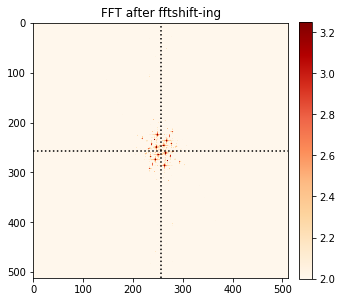

In [4]:
fft_image_raw = np.fft.fft2(stem_image)
fft_image_raw_shifted = np.fft.fftshift(fft_image_raw)
fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(np.log10(np.abs(fft_image_raw_shifted)), 
                        cmap=plt.cm.OrRd, vmin=2, vmax=3.25)
axis.axvline(x=fft_image_raw_shifted.shape[0] // 2, color='k', linestyle=':')
axis.axhline(y=fft_image_raw_shifted.shape[1]// 2, color='k', linestyle=':')
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('FFT after fftshift-ing');

## Filtering in the real and frequency domains: 
The atomically resolved image above appears to be quite noisy and the atomic columns are not clearly visible. Below we apply a Gaussian filter to the image both in real and frequency spaces. 

In [5]:
cropped_image = stem_image[:128, :128]
gaus_sigma = 2.0
gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)

fft_raw = np.fft.fftshift(np.fft.fft2(cropped_image))
fft_noise_rem = np.fft.fftshift(np.fft.fft2(cropped_image - gaussian_filtered))
fft_gaus_filt = np.fft.fftshift(np.fft.fft2(gaussian_filtered))

## Visualize the filtered images in real and frequency spaces:

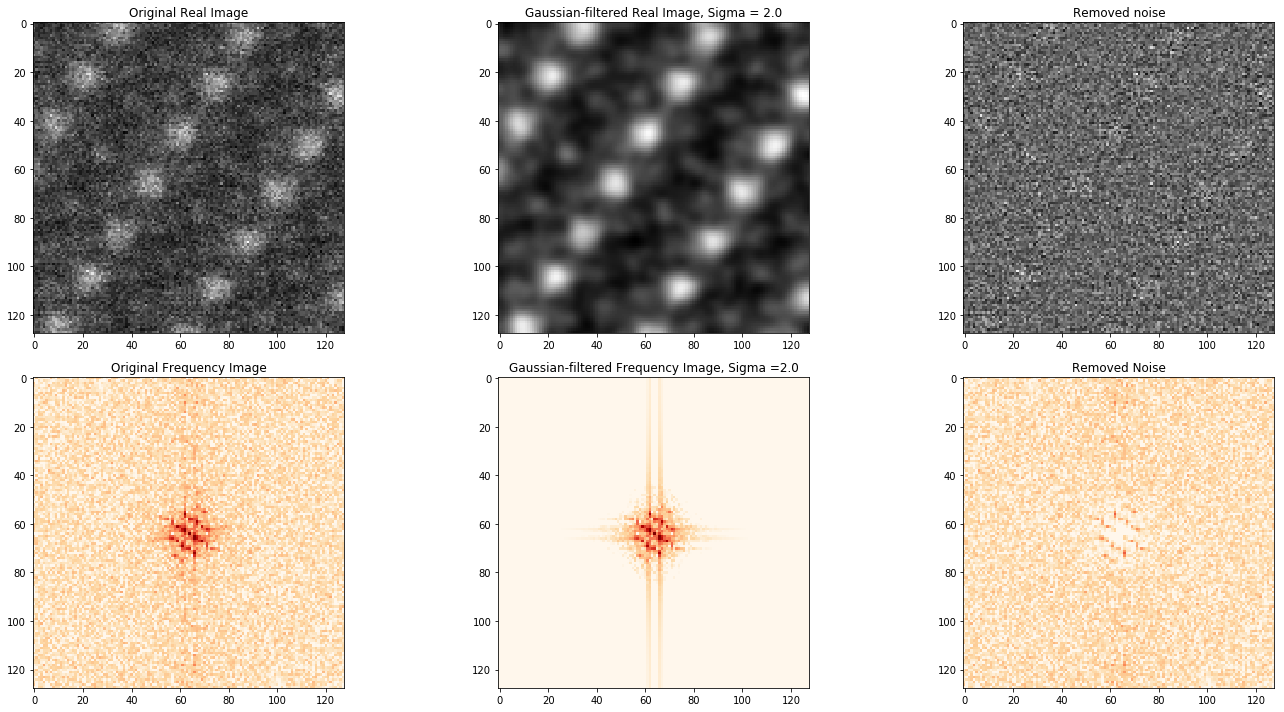

In [6]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
axes[0,0].imshow(cropped_image, cmap='gray')
axes[0,0].set_title('Original Real Image')
axes[0,1].imshow(gaussian_filtered, cmap='gray')
axes[0,1].set_title('Gaussian-filtered Real Image, Sigma = {}'.format(gaus_sigma))
axes[0,2].imshow(cropped_image - gaussian_filtered, cmap='gray')
axes[0,2].set_title('Removed noise');
axes[1,0].imshow(np.log10(np.abs(fft_raw)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,0].set_title('Original Frequency Image');
axes[1,1].imshow(np.log10(np.abs(fft_gaus_filt)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,1].set_title('Gaussian-filtered Frequency Image, Sigma ={}'.format(gaus_sigma))
axes[1,2].imshow(np.log10(np.abs(fft_noise_rem)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,2].set_title('Removed Noise')
fig.tight_layout()

After filtering in freqeuncy space, the center of the image (low-frequency) remains more-or-less the same but the data outside the center (higher spatial frequencies) is drastically reduced in magnitude thereby resulting in a cleaner image. All the noise from the higher frequencies is visible in the removed noise

Thus, the Gaussian filter is essentially a low-pass filter

## Make the visualizer interactive

To interactively explore and visualize the effect of sigma on the filtered images, all we need to do is define the plots as a function of sigma. All the code in the function, have already been shown above. Afterwards, we simply create a slider with `widgets.IntSlider` and use `widgets.interact` to interface the slider with the function. `interact` automatically creates a user interface (UI) control for the graphs.

In [7]:
def viz_filter_effect(gaus_sigma): 
    gaus_sigma = gaus_sigma
    gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)
    fft_raw = np.fft.fftshift(np.fft.fft2(cropped_image))
    fft_gaus_filt = np.fft.fftshift(np.fft.fft2(gaussian_filtered))
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
    axes[0,0].imshow(cropped_image, cmap='gray')
    axes[0,0].set_title('Original Real Image')
    axes[0,1].imshow(gaussian_filtered, cmap='gray')
    axes[0,1].set_title('Gaussian-filtered Real Image, Sigma = {}'.format(gaus_sigma))
    axes[0,2].imshow(cropped_image - gaussian_filtered, cmap='gray')
    axes[0,2].set_title('Removed noise');
    axes[1,0].imshow(np.log10(np.abs(fft_raw)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
    axes[1,0].set_title('Original Frequency Image');
    axes[1,1].imshow(np.log10(np.abs(fft_gaus_filt)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
    axes[1,1].set_title('Gaussian-filtered Frequency Image, Sigma ={}'.format(gaus_sigma))
    axes[1,2].imshow(np.log10(np.abs(fft_noise_rem)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
    axes[1,2].set_title('Removed Noise')
    fig.tight_layout()

In the lines below, we:  
1) Define the lower and upper limits of sigma, and label the slider, and  
2) Use interact to link the slider with the function we've defined above and designate the value of `guas_sigma` is set by gaus_slide. 

In [8]:
gaus_slide = widgets.IntSlider(min=0, max=10, description='Sigma', continuous_update=True)
widgets.interact(viz_filter_effect, gaus_sigma=gaus_slide, continuous_update=True);

interactive(children=(IntSlider(value=0, description='Sigma', max=10), Output()), _dom_classes=('widget-intera…

## Make the interactive visualizer better

While the approach above works, it requires that the entire figure comprising six images be replotted each time after the kernel of the Guassian filter is adjusted. To do better, we can change the data prsented within each image. To do so, we can update the data in images that are dependent on sigma by:  
1) letting the plotting code stand alone (as opposed to within a definition)
2) assigning the plots to variables and  
2) use the `set_data` attribute to change the data presented within each image.

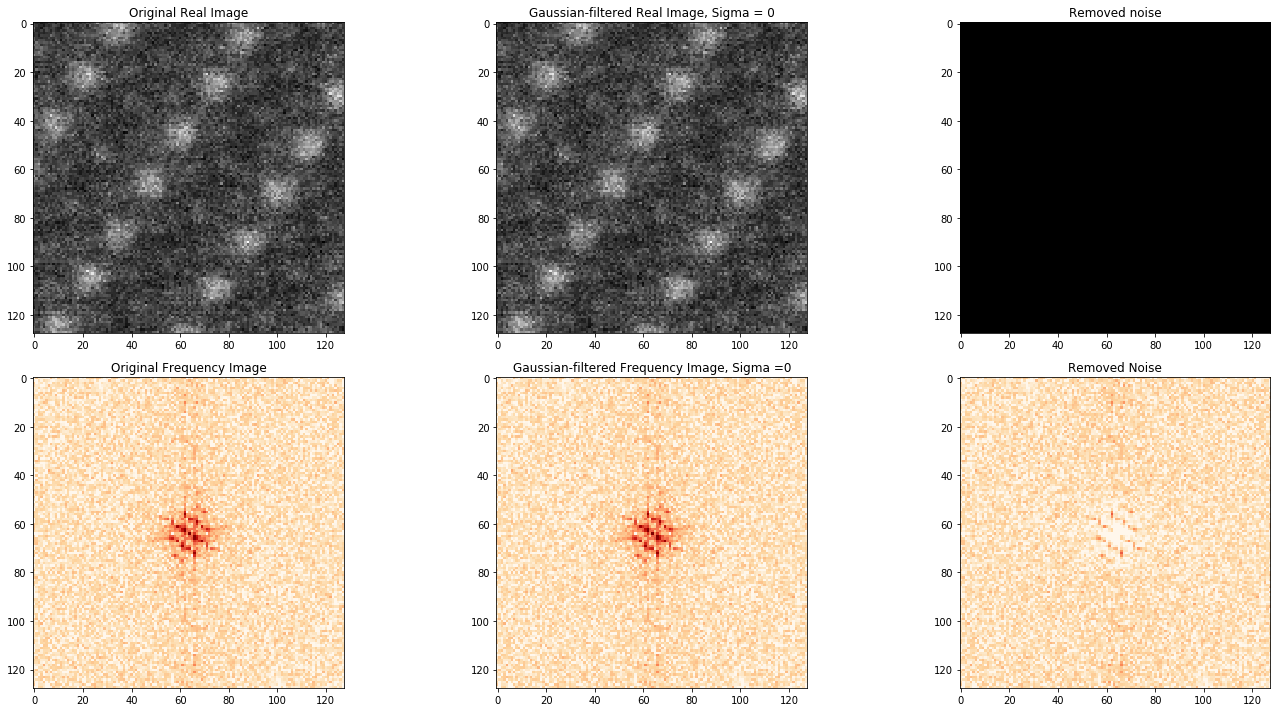

In [9]:
gaus_sigma = 0
gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)
fft_raw = np.fft.fftshift(np.fft.fft2(cropped_image))
fft_gaus_filt = np.fft.fftshift(np.fft.fft2(gaussian_filtered))

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
orig_img = axes[0,0].imshow(cropped_image, cmap='gray')
axes[0,0].set_title('Original Real Image')
gauss_filt_real = axes[0,1].imshow(gaussian_filtered, cmap='gray')
axes[0,1].set_title('Gaussian-filtered Real Image, Sigma = {}'.format(gaus_sigma))
rm_noise_real = axes[0,2].imshow(cropped_image - gaussian_filtered, cmap='gray')
axes[0,2].set_title('Removed noise');
orig_freq = axes[1,0].imshow(np.log10(np.abs(fft_raw)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,0].set_title('Original Frequency Image');
gauss_filt_freq = axes[1,1].imshow(np.log10(np.abs(fft_gaus_filt)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,1].set_title('Gaussian-filtered Frequency Image, Sigma ={}'.format(gaus_sigma))
rm_noise_freq = axes[1,2].imshow(np.log10(np.abs(fft_noise_rem)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,2].set_title('Removed Noise')
fig.tight_layout()

In [19]:
def change_gauss_filt(gaus_sigma):
    gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)
    fft_raw = np.fft.fftshift(np.fft.fft2(cropped_image))
    fft_gaus_filt = np.fft.fftshift(np.fft.fft2(gaussian_filtered))
    
    gauss_filt_real.set_data(gaussian_filtered)
#     axes[0,1].set_title('Gaussian-filtered Real Image, Sigma = {}'.format(gaus_sigma))
    rm_noise_real.set_data(cropped_image - gaussian_filtered)
#     gauss_filt_freq.set_data(np.log10(np.abs(filters.gaussian(cropped_image, sigma=gaus_sigma))))
    fig.canvas.draw()
    display(fig)
    
gaus_slide2 = widgets.IntSlider(min=0, max=10, description='Sigma', continuous_update=True)
widgets.interact(change_gauss_filt, gaus_sigma=gaus_slide2)


interactive(children=(IntSlider(value=0, description='Sigma', max=10), Output()), _dom_classes=('widget-intera…

<function __main__.change_gauss_filt(gaus_sigma)>

In [ ]:
gaus_sigma = gaus_sigma
gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)
fft_raw = np.fft.fftshift(np.fft.fft2(cropped_image))
fft_gaus_filt = np.fft.fftshift(np.fft.fft2(gaussian_filtered))


fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
orig_img = axes[0,0].imshow(cropped_image, cmap='gray')
axes[0,0].set_title('Original Real Image')
gauss_filt_real = axes[0,1].imshow(gaussian_filtered, cmap='gray')
axes[0,1].set_title('Gaussian-filtered Real Image, Sigma = {}'.format(gaus_sigma))
rm_noise_real = axes[0,2].imshow(cropped_image - gaussian_filtered, cmap='gray')
axes[0,2].set_title('Removed noise');
orig_freq = axes[1,0].imshow(np.log10(np.abs(fft_raw)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,0].set_title('Original Frequency Image');
gauss_fil_freq = axes[1,1].imshow(np.log10(np.abs(fft_gaus_filt)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,1].set_title('Gaussian-filtered Frequency Image, Sigma ={}'.format(gaus_sigma))
rm_noise_freq = axes[1,2].imshow(np.log10(np.abs(fft_noise_rem)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,2].set_title('Removed Noise')
fig.tight_layout()